Implementation of the paper "Random-Access Neural Compression of Material Textures," which presents a neural network-based approach to lossy texture compression.

References:
* [Sloppy Mortar Stone Wall PBR Material](https://freepbr.com/product/sloppy-mortar-stone-wall-pbr/)
* [Random-Access Neural Compression of Material Textures (2023)](https://research.nvidia.com/labs/rtr/neural_texture_compression/)

In [110]:
import torch
import matplotlib.pyplot as plt
import math

# Prepare data for compression
albedo = plt.imread('texture_set/sloppy-mortar-stone-wall_albedo.png')[:,:,:3]
normal = plt.imread('texture_set/sloppy-mortar-stone-wall_normal-dx.png')[:,:,:3]
ao = plt.imread('texture_set/sloppy-mortar-stone-wall_ao.png')[:,:,:1]
roughness = plt.imread('texture_set/sloppy-mortar-stone-wall_roughness.png')[:,:,:1]
height = plt.imread('texture_set/sloppy-mortar-stone-wall_height.png')[:,:,:1]

texture_set = torch.concat([ torch.from_numpy(t) for t in [albedo, normal, ao, roughness, height]], dim=-1)
assert texture_set.shape[0] == texture_set.shape[1] # Assume square texture
mip_level_num = math.floor(math.log2(texture_set.shape[0])) + 1

texture_set = texture_set.permute(2,0,1).unsqueeze(0) # 1, C, H, W
mip_levels = [texture_set]
for i in range(mip_level_num - 1):
    # NOTE: It isn't correct to use bilinear interpolation for all material attributes like I'm doing it here.
    #       I think this simplification might make it easier for the model to learn inter-channel correlation which might influence the results.
    #       For the sake of simplicity I'll leave it like that for now.
    texture_set = torch.nn.functional.interpolate(texture_set, scale_factor=0.5, mode='bilinear')
    mip_levels.append(texture_set)

# Hyperparameters
num_epoch = 1000
grid_lr = 0.01
mlp_lr = 0.005
batch_per_epoch_num = 8
samples_per_batch_num = 256 * 256
uniform_mip_level_sample_percentage = 0.05
g0_channels_num = 12
g1_channels_num = 20
piramid_feature_levels_num = 4
freq_num = math.floor(math.log2(8)) # Hardcoded 8 comes from the maximum upsampling factor going from G1 to target resolution (256 -> 2048).
mlp_input_channels_size = 4 * g0_channels_num + g1_channels_num + freq_num * 2 * 2 + 1 # 1 for mip level.
output_channels_size = 9 # albedo (rgb), normal (rgb), ao (r), roughness (r), height (r)

# Construct piramid feature levels that hold latent parameters for each mip level
piramid_feature_levels = []
grid_optimizers = []
grid_schedulers = []
for i in range(piramid_feature_levels_num):
    g0_size = (512 >> i*2)
    g1_size = (256 >> i*2)
    G0 = torch.empty((g0_size, g0_size, g0_channels_num), requires_grad=True)
    G1 = torch.empty((g1_size, g1_size, g1_channels_num), requires_grad=True)
    torch.nn.init.xavier_uniform_(G0)
    torch.nn.init.xavier_uniform_(G1)
    piramid_feature_levels.append( (G0, G1) )
    grid_optimizers.append( torch.optim.Adam( [G0, G1] , lr=grid_lr) )
    grid_schedulers.append( torch.optim.lr_scheduler.CosineAnnealingLR(grid_optimizers[-1], T_max=num_epoch, eta_min=0) )

def select_piramid_feature_level(mip_level : int):
    assert 0 <= mip_level < mip_level_num
    if mip_level < 4:
        return 0
    elif mip_level < 6:
        return 1
    elif mip_level < 8:
        return 2
    else:
        return 3

# Define MLP
mlp = torch.nn.Sequential( 
    torch.nn.Linear( mlp_input_channels_size, 64 ),
    torch.nn.GELU(),
    torch.nn.Linear( 64, 64 ),
    torch.nn.GELU(),
    torch.nn.Linear( 64, 64 ),
    torch.nn.GELU(),
    torch.nn.Linear( 64, output_channels_size ),
)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=mlp_lr)
mlp_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(mlp_optimizer, T_max=num_epoch, eta_min=0)
loss_func = torch.nn.MSELoss()

# Xavier initialization for the MLP
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
mlp.apply(init_weights)

def encode_position(uv : torch.Tensor, mip_level : int):

    piramid_feature_level = select_piramid_feature_level(mip_level)
    G0, G1 = piramid_feature_levels[piramid_feature_level]

    S = uv.shape[0]

    # Sample G0 (high frequency details) and construct input from 4 samples for learned interpolation.
    g0_size = torch.tensor(G0.shape[:2]).unsqueeze(0).expand(S, 2)

    g0_sample_00 = torch.min(torch.floor(uv * g0_size).to(dtype=torch.int32), g0_size-1)
    g0_sample_01 = torch.min(g0_sample_00 + torch.tensor([[0, 1]]), g0_size-1)
    g0_sample_10 = torch.min(g0_sample_00 + torch.tensor([[1, 0]]), g0_size-1)
    g0_sample_11 = torch.min(g0_sample_00 + torch.tensor([[1, 1]]), g0_size-1)

    x_00 = G0[g0_sample_00[:,0], g0_sample_00[:,1]]
    x_01 = G0[g0_sample_01[:,0], g0_sample_01[:,1]]
    x_10 = G0[g0_sample_10[:,0], g0_sample_10[:,1]]
    x_11 = G0[g0_sample_11[:,0], g0_sample_11[:,1]]

    mlp_input = torch.concat( [x_00, x_01, x_10, x_11], dim=-1 )

    # Sample G1 (low frequency details) and add interpolated samples to the input.
    g1_sample = uv * 2 - 1
    g1_sample = g1_sample.unsqueeze(0).unsqueeze(2) # 1, S, 1, 2
    grid = G1.permute(2, 0, 1).unsqueeze(0)
    x = torch.nn.functional.grid_sample(grid, g1_sample, mode='bilinear', padding_mode='border', align_corners=False)
    x = x.squeeze(0).squeeze(2).permute(1,0) # S, C

    mlp_input = torch.concat( [mlp_input, x], dim=-1 )

    # Add positional encoding to the input.
    powers = 2 ** torch.arange(0, freq_num) * torch.pi
    powers_x = torch.outer(uv[:,0], powers)
    powers_y = torch.outer(uv[:,1], powers)
    cossin_x = torch.cos(powers_x), torch.sin(powers_x)
    cossin_y = torch.cos(powers_y), torch.sin(powers_y)

    pe = torch.cat( [cossin_x[0], cossin_x[1], cossin_y[0], cossin_y[1]], dim=1 )

    mlp_input = torch.concat([mlp_input, pe], dim=-1)

    # Add normalized mip level to the input.
    mlp_levels = torch.full((S, 1), fill_value=mip_level / (mip_level_num - 1))
    mlp_input = torch.concat([mlp_input, mlp_levels], dim=-1)

    return mlp_input

mip_levels_selection_count = [[] for _ in range(mip_level_num)]
loss_per_mip_level_visualization = [[] for _ in range(mip_level_num)]
loss_per_mip_level_epochs = [[] for _ in range(mip_level_num)] 

for epoch in range(num_epoch):
    loss_avg_per_mip_level = torch.zeros(mip_level_num)
    mip_level_selection_count_local = torch.zeros(mip_level_num, dtype=torch.int32)

    for batch in range(batch_per_epoch_num):
        r = torch.rand(2)
        # Select mip level based on the mip level's area.
        # To mitigate understample of the higer levels, for 5% of batches we select mip level uniformly.
        batch_mip_level = -math.log(max(r[1].item(), 1e-10), 4) if r[0] > uniform_mip_level_sample_percentage else torch.randint(0, len(mip_levels), (1,)).item()
        
        batch_mip_level = min(math.floor(batch_mip_level), mip_level_num - 1)
        batch_piramid_feature_level = select_piramid_feature_level(batch_mip_level)

        batch_texture_set = mip_levels[batch_mip_level]
        G0, G1 = piramid_feature_levels[batch_piramid_feature_level]
        grid_optimizer = grid_optimizers[batch_piramid_feature_level]

        # NOTE: This is a bit different from the approach mentioned in paper.
        #       They select random 256x256 blocks while I select 256x256 random samples from the whole mip level.
        uv = torch.rand((samples_per_batch_num, 2))

        # Forward pass
        mlp_input = encode_position(uv, batch_mip_level)
        mlp_output = mlp(mlp_input)

        # Sample ground truth from the mip level
        sample_grid = uv * 2 - 1
        sample_grid = sample_grid.unsqueeze(0).unsqueeze(2) # 1, S, 1, 2
        ref_samples = torch.nn.functional.grid_sample(batch_texture_set, sample_grid, mode="bilinear", padding_mode='border', align_corners=False)
        ref_samples = ref_samples.squeeze().permute(1,0) # S, C

        loss_value = loss_func(mlp_output, ref_samples)

        # Optimize
        grid_optimizer.zero_grad()
        mlp_optimizer.zero_grad()

        loss_value.backward()

        mlp_optimizer.step()
        grid_optimizer.step()

        # Update per batch visualization data
        with torch.no_grad():
            loss_avg_per_mip_level[batch_mip_level] += loss_value
            mip_level_selection_count_local[batch_mip_level] += 1

    # Update learning rate scheduler for MLP
    mlp_scheduler.step()
    for scheduler in grid_schedulers:
        scheduler.step()

    # Update per epoch visualization data
    with torch.no_grad():
        for mip_level, count in enumerate(mip_level_selection_count_local):
            mip_levels_selection_count[mip_level].append(count.item())
            if count > 0:
                avg_loss = (loss_avg_per_mip_level[mip_level] / count).item()
                loss_per_mip_level_visualization[mip_level].append(avg_loss)
                loss_per_mip_level_epochs[mip_level].append(epoch)


#### Visualization of the training data:

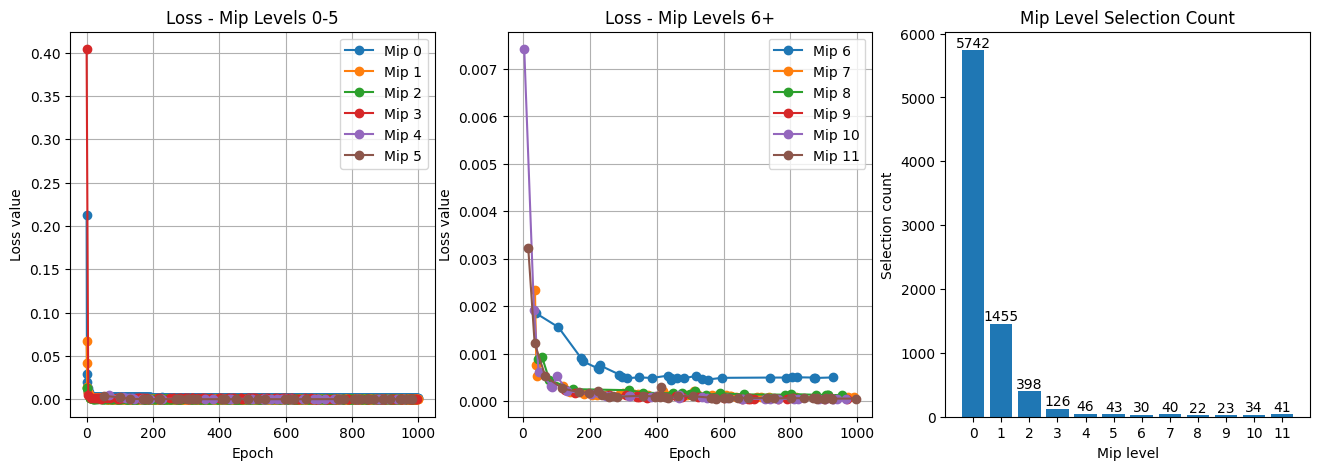

In [111]:
# Visualize loss values
# Plot 1: First half of mip levels
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Loss - Mip Levels 0-5')
for mip_level in range(min(6, mip_level_num)):
    if loss_per_mip_level_visualization[mip_level]:
        plt.plot(loss_per_mip_level_epochs[mip_level], loss_per_mip_level_visualization[mip_level], 
                 'o-', label=f'Mip {mip_level}')
plt.legend()
plt.grid(True)

# Plot 2: Second half of mip levels
plt.subplot(1, 3, 2)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Loss - Mip Levels 6+')
for mip_level in range(6, mip_level_num):
    if loss_per_mip_level_visualization[mip_level]:
        plt.plot(loss_per_mip_level_epochs[mip_level], loss_per_mip_level_visualization[mip_level], 
                 'o-', label=f'Mip {mip_level}')
plt.legend()
plt.grid(True)

# Visualize mip level's selection count
plt.subplot(1, 3, 3)
x = torch.arange(mip_level_num, dtype=torch.int32)
plt.xlabel('Mip level')
plt.ylabel('Selection count')
plt.title('Mip Level Selection Count')
plt.xticks(x)
bars = plt.bar(x, [sum(counts) for counts in mip_levels_selection_count])
for idx, bar in enumerate(bars):
    value = sum(mip_levels_selection_count[idx])
    y_pos = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    plt.text(x_pos, y_pos, str(value), ha='center', va='bottom')

#### PSNR for different mip levels:

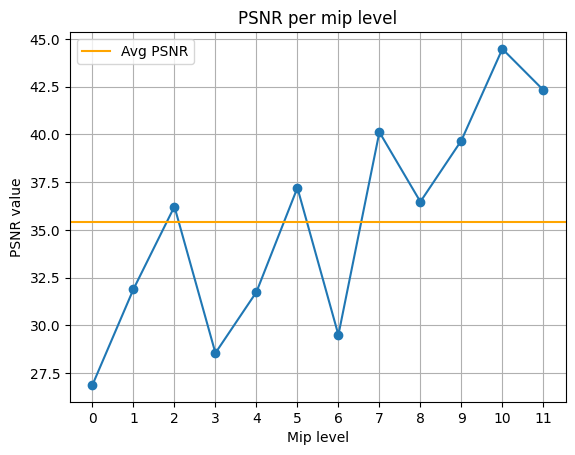

In [112]:
with torch.no_grad():
    psnr_per_mip_level = torch.zeros(mip_level_num)
    for mip_level in range(0, mip_level_num):
        original_material = mip_levels[mip_level].squeeze(0).permute(1,2,0)
        h, w, c = original_material.shape

        u = (torch.arange(0, h, dtype=torch.float32) + 0.5) / h
        v = (torch.arange(0, w, dtype=torch.float32) + 0.5) / w

        grid_uv = torch.stack( torch.meshgrid(u, v, indexing='xy'), dim=-1 ).reshape(-1,2)

        mlp_input = encode_position(grid_uv, mip_level)

        reconstructed_material = mlp(mlp_input)
        reconstructed_material = reconstructed_material.reshape(h, w, -1)

        mse = torch.mean((reconstructed_material - original_material) ** 2)
        mse = torch.inf if mse == 0 else mse
        psnr = 10 * torch.log10(1.0 / (mse + 1e-20))
        psnr_per_mip_level[mip_level] = psnr.item()

    x = torch.arange(mip_level_num, dtype=torch.int32)
    plt.xlabel('Mip level')
    plt.ylabel('PSNR value')
    plt.xticks(x)
    plt.title('PSNR per mip level')
    plt.plot(x, psnr_per_mip_level, 'o-')

    avg_psnr = torch.mean(psnr_per_mip_level)
    plt.axhline(y=avg_psnr, color='orange', label="Avg PSNR")

    plt.grid(True)
    plt.legend()

#### Visualization for the mip level 0:

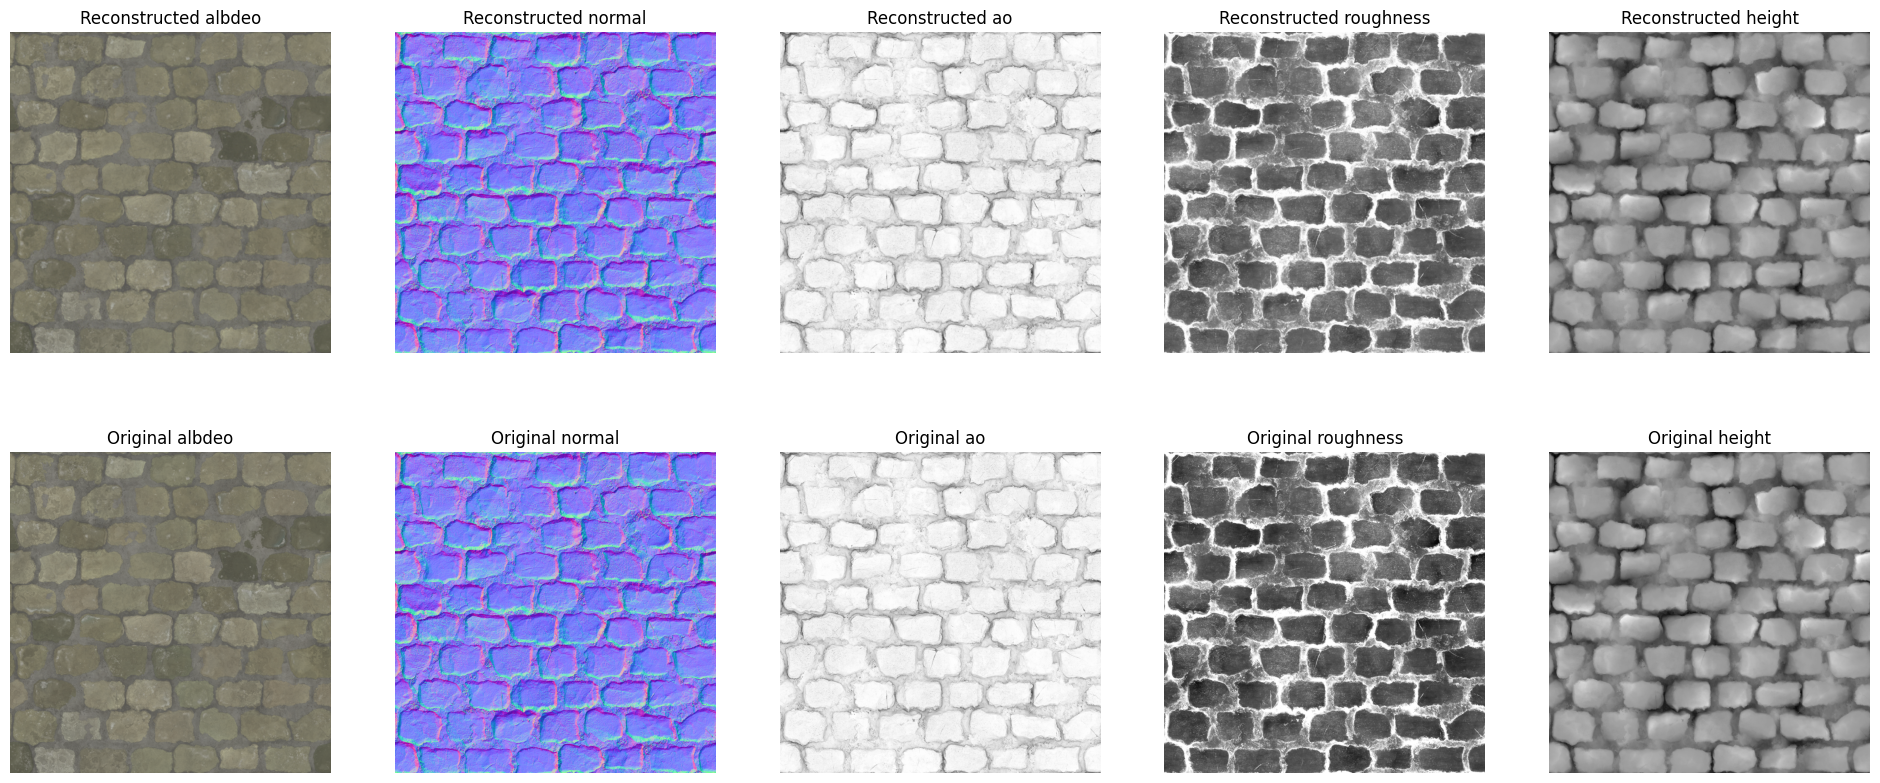

In [113]:
with torch.no_grad():
    mip_level = 0
    original_material = mip_levels[mip_level].squeeze(0).permute(1,2,0)
    h, w, c = original_material.shape

    u = (torch.arange(0, h, dtype=torch.float32) + 0.5) / h
    v = (torch.arange(0, w, dtype=torch.float32) + 0.5) / w

    grid_uv = torch.stack( torch.meshgrid(u, v, indexing='xy'), dim=-1 ).reshape(-1,2)

    mlp_input = encode_position(grid_uv, mip_level)

    reconstructed_material = mlp(mlp_input)
    reconstructed_material = reconstructed_material.reshape(h, w, -1)

    reconstructed_albdeo = reconstructed_material[:,:,:3]
    reconstructed_normal = reconstructed_material[:,:,3:6]
    reconstructed_ao = reconstructed_material[:,:,6:7]
    reconstructed_roughness = reconstructed_material[:,:,7:8]
    reconstructed_height = reconstructed_material[:,:,8:9]

    original_albdeo = original_material[:,:,:3]
    original_normal = original_material[:,:,3:6]
    original_ao = original_material[:,:,6:7]
    original_roughness = original_material[:,:,7:8]
    original_height = original_material[:,:,8:9]

    fig = plt.figure(figsize=(24,10))

    def show_image(index, title, img):
        plt.subplot(2, 5, index)
        img = img.clamp(0.0, 1.0).cpu().numpy()
        plt.imshow(img, cmap='gray' if img.shape[2] == 1 else 'viridis')
        plt.axis('off')
        plt.title(title)

    show_image(1, 'Reconstructed albdeo', reconstructed_albdeo)
    show_image(2, 'Reconstructed normal', reconstructed_normal)
    show_image(3, 'Reconstructed ao', reconstructed_ao)
    show_image(4, 'Reconstructed roughness', reconstructed_roughness)
    show_image(5, 'Reconstructed height', reconstructed_height)

    show_image(6, 'Original albdeo', original_albdeo)
    show_image(7, 'Original normal', original_normal)
    show_image(8, 'Original ao', original_ao)
    show_image(9, 'Original roughness', original_roughness)
    show_image(10, 'Original height', original_height)